# Bayesian Asians Final Project: Predicting Music Popularity

# Overview and Motivation 

<img width=600 height=400 src="http://icdn8.digitaltrends.com/image/music-header-625x1000.jpg"/>

**Provide an overview of the project goals and the motivation for it. Consider that this will be read by people who did not see your project proposal** 

In an age where music is hip one day and old the next, what does it mean for artists or songs to be popular? And if we knew what popular meant, is there a good way for people to predict popularity, to predict new trends? 

Today we take a look at modelling popularity with song information. We won't look at music as it trends over time, instead focusing on whether at any snapshot moment in time we are able to take a song or artist and, given what we information we can, attempt to predict its popularity. 

Our main goals involve: 

**(1)** Understanding how members of the music industry define features of music (such intense features such as "danciness", "hotness", and "speechiness")

**(2)** Assessing which, if any, of these available features can give us a good signal the popularity of songs and artists (to be defined below)

**(3)** Assessing how well we can predict a song's popularity by such summary statistics

On top of this, we aim to:

**(4)** Analyze lyrics for each song and construct additional predictive features from this

(Image credit: http://www.digitaltrends.com/music/the-beauty-of-data-in-music-discovery-how-to-use-it-to-find-the-next-music-sensation/)

Let's begin by importing and getting all the packages we need!

In [2]:
import urllib2
import os
import ast
import time
import re
import numpy as np
import requests
from urllib2 import HTTPError
from httplib import BadStatusLine

import cPickle
import numpy.random as random

from os import listdir

%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# Related Work

**Anything that inspired you, such as a paper, a web site, or something we discussed in class.**

When we were doing homework 1, we thought to ourselves, "This is so cool! But what if we could go further...". We were initially inspired by how a seemingly simple task of assessing popularity could be so multilayered and faceted, approached from a variety of angles. And initially, we lacked the technical knowhow (and time) to significantly improve upon the analyses that the homework challenged us to do. 

But we have that now! And so we started to research the topic. 

We found that there was an abundance of data that we could leverage in interesting ways, and several other websites that claimed to be able to predict "music's next hit". And so we did what any aspiring data scientists would do: 

We asked, "can we do better?"

# Initial Questions

**What questions are you trying to answer? How did these questions evolve over the course of the project? What new questions did you consider in the course of your analysis? - Data: Source, scraping method, cleanup, storage, etc.**

The main questions we tried to answer were: 

**(1)** How can we assess the popularity of a song? 

**(2)** How can we predict the popularity of a song based on the features we have and any constructed features? 

Our main source of data was the Echo Nest, an API specializing in music data with a developed and built out platform including extensive tools and libraries. It includes an insane number of data points from a diverse group of media companies and even recently partnered with Spotify to include their music information as well.  

Because of this, our questions quickly turned to:

**(1)** Why is there so much music data? And,

**(2)** Why the heck does Echo Nest spell "hotness" as "hotttnesss"? 

To get at our data, we leveraged the Echo Nest API to pull song information. In order to make sure that we could pull all this data (see **(1)**), we had many API keys that were pulling simultaneously.

In [3]:

API_KEYS = ['CBCEMBUU5RKMZCANM','EJCLKDYO0IG8BPAMD','N1BKLELC5KB7IBR6K', 'KESZKE2QUN4SVPNHC',
		'FJRU9KPN5HVDJK8EZ', 'NLFXA1IBUGVSWCIFQ', 'F0ABVNJI3MVUYSSQJ', 'B1KXAHKSVAXRNQSEW',
		'GE8QKD8K9LTZJOUSW', 'OO0TYEIFXLCSTVEZ7', 'U2W0OZHN52FM4HW9K', 'AAVGZKDPBNKWOBMRM', 
		'1M1F5GLMPOQ1PAIVI', 'UJ8CU9AISIVDZPYDX', 'MLQHLZWLSRXZ3VKWM', 'GP1TQLH0UMYBWSWY1', 
		'9QX6MXTEZXIFRQHR9', 'CCLZCYBZW5RRNFJIV', 'GNPX5JOKHDWGK201K', 'GW0FZNNQZZFISWDPU', 
		'ERKK9SPSKBJZWULNK', 'IXSAQDFFLJFL98CWW', 'ZD2RT50EO6V7IZ9BC', 'ELC9POZKIDYTHURAX',
		'IJMKESRYUTLWQP9VN', 'VMAIHRDPYE8ZWGBRK', 'H4CSPTRC996SCDAWX', 'RJTL5RUUMY7Y94JZY',
		'GD1LZYWFFAH8NX5WT', '3HEGCDTFC3XAYELGJ', 'EQIGA9KKDFX0OBAM7', 'JEJODYWILNWSAHDKR',
		'2OBYASF4JYKO3N8G6']

class SongBase:
	"""
	An extension of a string class. This substitutes the API Keys into the song titles,
	one at a time, and swaps them out as used. This allows us to make continuous calls to
	an API, without looking like we are doing so.
	"""
	def __init__(self, keys, postfix, prefix='http://developer.echonest.com/api/v4/artist/search?api_key='):
		self.keys = keys
		self.prefix = prefix
		self.postfix = postfix
		self.cur = 0

	def __add__(self, other):
		val = self.prefix+self.keys[self.cur]+self.postfix+other

		self.cur += 1
		if self.cur == len(self.keys):
			self.cur = 0

		return val

	def __radd__(self, other):
		val = other+self.prefix+self.keys[self.cur]+self.postfix

		self.cur += 1
		if self.cur == len(self.keys):
			self.cur = 0

		return val

	def __iadd__(self, other):
		self.postfix += other
		return self

# Minimum amount of sleep time between calls
SLEEP_MIN = 0.5

# Time to sleep between errors
SLEEP_ERROR=10

# How to search the database for an artist
ARTIST_SEARCH_BASE = SongBase(API_KEYS, '&format=json&sort=song_hotttnesss-desc&results=99', 'http://developer.echonest.com/api/v4/song/search?api_key=')

# How to search the database for a song
SONG_SEARCH_BASE = SongBase(API_KEYS, '&format=json&sort=song_hotttnesss-desc&results=99', 'http://developer.echonest.com/api/v4/song/search?api_key=')

# The attributes that matter when searching the database for a specific song profile
attrs = ['audio_summary', 'artist_discovery', 'artist_discovery_rank', 'artist_familiarity', 'artist_familiarity_rank', \
			'artist_hotttnesss', 'artist_hotttnesss_rank', 'artist_location', 'song_currency', 'song_currency_rank', \
			'song_hotttnesss', 'song_hotttnesss_rank', 'song_type', 'tracks', 'id:musixmatch-WW']

# How to search for a song profile
SONG_PROFILE = SongBase(API_KEYS, '&format=json', 'http://developer.echonest.com/api/v4/song/profile?api_key=')

# Adding to this! All the attributes must be added on
SONG_PROFILE_BASE = SongBase(API_KEYS, '&format=json', 'http://developer.echonest.com/api/v4/song/profile?api_key=')
for a in attrs:
	SONG_PROFILE_BASE += "&bucket="+a

Echo Nest has very little support for searching through its database. We first attempted to go through their database page by page, searching for all of the songs that we needed. This led to the function:

In [ ]:
def database_search(basestr=ARTIST_SEARCH_BASE, maxval=10, sleep=SLEEP_MIN, verbose=False): 
	"""
	This function searches through the echonest database. We need it because the 
	echonest database can only return 99 results on a single page - as a result, to
	get anything meaningful, we have to search through multiple pages
	"""
	try:
		# Attempt the initial search
		artists = [urllib2.urlopen(basestr).read()]
		time.sleep(sleep)
	except HTTPError as e:
		# If we have already failed
		if verbose:
			print e
			print "SLEEPING FOR %d SECONDS" % SLEEP_ERROR
		time.sleep(SLEEP_ERROR)
		
		# Python will handle the infinite loop issue
		return database_search(basestr, maxval, sleep, verbose)

	for i in xrange(1,maxval):
		# Search through the rest of the pages
		try:
			artists.append(urllib2.urlopen(basestr+"&start="+str(i*99)).read())
			time.sleep(sleep)
			if verbose:
				print "FINISHED WEBPAGE %d" % i
		except HTTPError:
			if verbose:
				print "SLEEPING FOR %d SECONDS; TOO MANY REQUESTS" % SLEEP_ERROR
			time.sleep(SLEEP_ERROR)

			# Force it to try to get the page again if an error occured
			i -= 1

	return artists

But, we then found out that their API only allows us to pull the top 10,000 values in any given cateogry, so any pages past 100 were completely useless (at 100 results per page). As a result, we decided that we could start with the artists. We could sort the artists by hotttnesss (see **(2)**), and then bound hotttnesss in specific periods.

In [ ]:
def full_artists(n=100, minval=0, maxval=1, **kwargs):
	"""
	Grabs all of the information for our artists - gets them sorted by hotttnesss
	so that the 10k maximum length is okay.
	"""
	hotness = np.linspace(minval, maxval, n)
	artists = database_search(ARTIST_SEARCH_BASE+"&max_hotttnesss="+str(hotness[1]), **kwargs)
	artists.extend(database_search(ARTIST_SEARCH_BASE+"&min_hotttnesss="+str(hotness[-2]), **kwargs))
	for i in xrange(2,len(hotness)-2):
		curstr = ARTIST_SEARCH_BASE+"&max_hotttnesss="+str(hotness[i])+"&min_hotttnesss="+str(hotness[i-1])
		artists.extend(database_search(curstr, **kwargs))
		print "FINISHED %.4f Percent" % (float(i+1)/len(hotness))
	return artists

With all of the crazy server responses that we were receiving, it only made sense to actually begin a function that will parse an arbitrary JSON file and look for a specific field.

Why not use a ast.eval_literal? We could have used that to evaluate the JSON and find the field we wanted. However, this method would have been far too slow - we wanted something that was more scalable.

In [ ]:
def get_field(data, field="name", value=None):
	"""
	Takes a JSON response object and grabs a relevant field from it
	"""
	# We only deal in arrays, so a single response becomes an array
	if data.__class__ == str:
		data = [data]

	# Likewise, if garbage input is passed in, we want to get rid of it
	if not np.iterable(data):
		raise ValueError("Yo bro data isn't iterable! Check it?")

	# Nope, no more garbage input
	if (value.__class__ != str) and (value is not None):
		raise ValueError("Yo dude you passed in a bad value for value.")

	# This is where we will save our data
	output = {}
	for resp in data:
		# Look for the first instance where the response starts
		artists = resp.split("[")[1].split("{\"")[1:]
		for a in artists:
			try:
				# Grab the name that split the response
				name = a.split(field)[1][4:].split("\"")[0]
				if value is None:
					output[name] = None
				else:
					val = a.split(value)[1][4:].split("\"")[0]
					if name in output:
						output[name].append(val)
					else:
						output[name] = [val]
			except IndexError:
				# Response doesn't exist
				pass

	return output

Echo Nest has no lyrics data - and as a result, we wrote some other functions to be able to grab lyrics from other websites. The main one was MusixMatch:

In [ ]:
LYRICS_BASE = 'http://api.musixmatch.com/ws/1.1/track.lyrics.get?apikey=3476eaa823bbdd8fc9b8fe89ee98c387'
NLY_BASE = "http://www.lyrics.com"

def pull_lyrics(fids):
	"""
	Pulls lyrics from our musixmatch api-key
	"""
	if len(fids) == 0:
		return []

	responses = []
	for f in fids:
		code = int(f['foreign_id'].split(":")[-1])
		responses.append(urllib2.urlopen(LYRICS_BASE+"&track_id="+str(code)).read())

	return responses

Because we were heavily rate limited (and we were only allowed to have one API key each for this website), we also wrote some functions to take advantage of external lyrics databases:

In [ ]:

def gen_database(dbfile, which=1):
	"""
	Takes a SQLite database output file 
	"""
	output = {}
	with open(dbfile, 'r') as f:
		for x in xrange(17):
			f.next()
		words = f.next().strip().split(",")[1:]
		for line in f:
			song = line.strip().split(",")
			odict = {}
			for s in song[2:]:
				vals = s.split(":")
				if len(vals) != 2:
					raise ValueError("Not Formatted as Expected")
				odict[int(vals[0])-1] = int(vals[1])

			output[song[which]] = odict
	return words, output

def grab_lyrics_az(params=['hello', 'adele'], urlbase='http://search.azlyrics.com/search.php?q=', throw_except=False):
	"""
	Grabs lyrics from azlyrics.com
	"""
	# Set up URL
	url = urlbase
	for p in params:
		url += p+"+"
	url = url[:-1]
	print url

	# Read and split into correct pieces
	try:
		r = urllib2.urlopen(url).read()
	except BadStatusLine:
		if throw_except:
			raise ValueError("Bad URL!")
		return []

	tl = r.split("text-left visitedlyr")[1:]

	# Grab hyperlinks
	hrefs = [t.split('href')[1].split('target')[0][2:-2] for t in tl]

	# Process into lyrics
	output = []
	for ur in hrefs:
		try:
			resp = urllib2.urlopen(ur).read()
			output.append(re.sub(r'\<.*?\>', '', resp.split('cf_text_top')[1][2:]).split('Android')[0][-8].strip())
		except BadStatusLine:
			if throw_except:
				raise ValueError("Bad URL!")
		time.sleep(SLEEP_BASE)

	return output

def grab_lyrics(params=['hello', 'adele'], urlbase="http://www.lyrics.com/search.php?keyword=", urlpost="&what=all&search_btn=Search"):
	"""
	Grabs lyrics from lyrics.com
	"""
	# Set up URL
	url = urlbase
	for p in params:
		url += p+"+"
	url = url[:-1]+urlpost
	
	# Read and split into correct pieces
	try:
		r = urllib2.urlopen(url).read()
		time.sleep(SLEEP_BASE)
	except BadStatusLine:
		if throw_except:
			raise ValueError("Server stopped connecting!")
		return []

	try:
		tl = r.split("rightcontent")[1].split("bottom_wrapper")[0].split("href")[1:-1]

		# Grab hyperlinks
		hrefs = []
		for t in tl:
			vals = t.split("class=")
			if (len(vals) > 1) and (vals[1][1:15] == 'lyrics_preview'):
				hrefs.append(NLY_BASE+vals[0][2:-2])

		# Process into lyrics
		output = []
		for ur in hrefs:
			try:
				resp = urllib2.urlopen(ur).read()
				try:
					output.append(re.sub(r'\<.*?\>', '', resp.split("lyric_space")[1].split("itemprop=")[1][14:].split("class=\"PRINTONLY\"")[0][:-42]).strip())
				except IndexError:
					pass
			except BadStatusLine:
				if throw_except:
					raise ValueError("Server Stopped Responding!")
			time.sleep(SLEEP_BASE)
	except IndexError:
		# Implies that no lyrics exist
		return []

	return output

In addition, after getting all of that data, we realized that there was no good way to store it. Artist data is a hodgepodge of random stuff - and we didn't have a method that we could queue results on an directly read the results into files. As a result, we wrote a function that would lock the next value until we were done processing previous values, eliminating extra work that we had to do.

In [ ]:

class CachedData:
	"""
	This class stores all of our data. What it does is it holds dictionaries that
	are updated as a process is running. That way, if a process fails or errors out,
	our data will still exist and we can still retrieve it
	"""
	def __init__(self, input_dict):
		self.internal_dict = [(k,v) for k,v in input_dict.iteritems()]
		self.cur_index = 0
		self.data_dict = {}
		self.failed_dict = {}
		self.frozen = False

	def intersect(self, input_dict, output={}):
		"""
		Determine which part of the input dict is in this cacheddata instance;
		the rest is thrown out as failed.

		Can iteratively add to it using the output kwarg
		"""
		failed = {}
		for v in self.data_dict.itervalues():
			if v.name in input_dict:
				output[v.name] = v
		
		for k,v in input_dict.iteritems():
			if k not in output:
				failed[k] = v

		return output, failed

	def remaining(self):
		"""
		Tells you how many values are remaining to process
		"""
		return len(self.internal_dict)-self.cur_index

	def permute(self):
		"""
		Permutes the values, for random ordering later for multiple people processing.
		"""
		neworder = np.random.permutation(xrange(len(self.internal_dict[self.cur_index:])))
		newarr = [None]*len(self.internal_dict)
		for i in xrange(self.cur_index):
			newarr[i] = self.internal_dict[i]

		for i, v in enumerate(neworder):
			newarr[i+self.cur_index] = self.internal_dict[v]

		self.internal_dict = newarr

	def get(self):
		"""
		Gets the next value to be processed, except if we haven't called success()
		or failed() - in that case, it repeatedly returns the old object until
		you decide that the process was a success or failure
		"""
		if self.frozen == True:
			return self.internal_dict[self.cur_index-1]

		if self.cur_index == len(self.internal_dict):
			raise IndexError("No more values!")

		self.cur_index += 1
		self.frozen = True
		return self.internal_dict[self.cur_index-1]

	def success(self, data):
		"""
		Log the last data point as a success
		"""
		self.data_dict[self.cur_index-1] = data
		self.frozen = False

	def failed(self):
		"""
		Log the last data point as a failure
		"""
		k,v = self.internal_dict[self.cur_index-1]
		self.failed_dict[k] = v
		self.frozen = False

In addition, we realized just how messy song responses are - there are random fields, sometimes they don't exist, sometimes they exist in others. Artists sometimes have songs that are Null, but we don't want to just report that a song doesn't exist. These issues led us to believe that we wanted a structured way to represent artists and songs that we could use later in the analysis.

In [ ]:

class Song:
	"""
	A class that holds all of our data for song information. As we are pulling
	the data from the online database, this object will handle processing+getting
	its own lyrics, etc. 

	Just so that the structures are more organized.
	"""
	def __init__(self, name, idvals, resp, verbose=True):
		self.name = name
		self.id = idvals
		self.lyrics = None

		# Process each of the responses that are associated with this song.
		self.resp = []
		for r in resp:
			try:
				try:
					self.resp.append(ast.literal_eval(r[0])['response']['songs'][0])
				except ValueError:
					try:
						self.resp.append(ast.literal_eval(r[0].replace("null", "None"))['response']['songs'][0])
					except ValueError:
						if verbose:
							print "Error on Song %s, ID Number %d" % (self.name, len(self.resp))
						self.resp.append(r[0])
			except IndexError:
				self.resp.append({})

		# Cleaning to prevent duplicates
		for r in self.resp:
			try:
				r['title'] = re.sub(r'\(.*?\)', '', r['title']).strip()
			except KeyError:
				raise ValueError("Title Doesn't Exist!")

	def get_ids(self, which='foreign_id'):
		"""
		Get the MusiXMatch ID values so that we can grab lyrics from their database
		"""
		output = []
		[output.extend([td[which].split(":")[-1] for td in r['tracks']]) for r in self.resp]
		return output

	def from_database(self, db, **kwargs):
		"""
		Takes a dictionary "database" and picks out its own song lyrics. The database
		must be keyed by a musixmatch key of some sort (one that exists in this response)
		"""
		if self.lyrics is not None:
			raise ValueError("Lyrics already Exist!")

		flag = False
		self.lyrics = []
		id_list = self.get_ids(**kwargs)
		for i in id_list:
			if i in db:
				self.lyrics.extend([db[i]])
				flag = True

		if flag:
			return True
		else:
			return False

	def get_lyrics(self, get_full=True):
		"""
		Gets the lyrics from an external database - grabs them from online.
		Which online other site is chosen by changing what grab_lyrics() does,
		since this doesn't have to be done often
		"""
		self.lyrics = []
		if get_full:
			for r in self.resp:
				params = r['artist_name'].split(" ")
				params.extend(r['title'].split(" "))
				self.lyrics.extend(grab_lyrics(params))
		else:
			for r in self.resp:
				self.lyrics.extend(pull_lyrics(r['foreign_ids']))

		return self.lyrics

	def __str__(self):
		"""
		Make it print prettily
		"""
		return "Song %s with %d attributes" % (self.id, np.sum([len(r) for r in self.resp]))

	def __repr__(self):
		"""
		Make it print prettily
		"""
		return self.__str__()

class Artist:
	"""
	Because of how the Echonest database is set up, the Artist class is set up
	to hold all of the information about the artist. From here, we can process
	songs and generate all of the songs that correspond to a given artist.
	"""
	def __init__(self, name, resp):
		"""
		Most of the time you won't use this - use a class method instead.
		"""
		if (name.__class__ != str) and (name.__class__ is not None):
			raise ValueError("Artist Name must be either a string or none")

		self.name = name
		self.songs = {}
		self.processed = False

		if resp is None:
			return

		elif resp.__class__ == dict:
			self.songs = resp
			return self

		elif resp.__class__ == str:
			titles = resp.split("[")[1].split("title")[1:]
			ids = resp.split("[")[1].split("\"id")[1:]
			for i in xrange(len(titles)):
				self.songs[titles[i][4:].split("\"")[0]] = [ids[i][4:].split("\"")[0]]
			return

		elif resp.__class__ == list:
			self.songs = get_field(resp, "title", value='\"id')
			return

		raise ValueError("Plz give me a string!")

	def process(self, verbose=False):
		"""
		Processes all the songs that are internal to this artist.
		"""
		if self.processed == True:
			return

		for k,v in self.songs.iteritems():
			try:
				self.songs[k] = Song(k, v, [database_search(SONG_PROFILE_BASE+"&id="+val, 1, verbose=verbose) for val in v])
			except:
				time.sleep(SLEEP_ERROR)
				self.songs[k] = Song(k, v, [database_search(SONG_PROFILE_BASE+"&id="+val, 1, verbose=verbose) for val in v])

		self.processed = True

	@classmethod
	def add(cls, first, second):
		"""
		Takes two artists and adds them together into a third
		"""
		if first.name != second.name:
			raise ValueError("Can only add together artists of the same name!")

		song = np.copy(first.songs)
		for k,v in second.songs.iteritems():
			song[k] = v

		return cls(first.name, song)

	@classmethod
	def from_name(cls, name, ids, basestr=SONG_SEARCH_BASE):
		"""
		Takes an artist name and echonest ID and then constructs a fully
		processed artist object from it.
		"""
		output = []
		for i in ids:
			query = basestr+"&artist_id="+i
			try:
				output.append(cls(name, database_search(query, maxval=3)))
			except HTTPError as e:
				print e
				raise ValueError("You failed.")

		cur = output[0]
		for i in xrange(1,len(output)):
			cur = cls.add(cur, output[i])

		return cur

	@classmethod
	def from_cached(cls, cacheddata):
		"""
		Takes an instance of CachedData and generates artist objects inside of it,
		just in case a long computation fails and we still want all of the results
		that we already have.
		"""
		total = len(cacheddata.internal_dict)
		left = cacheddata.cur_index
		for i in xrange(total-left):
			k,v = cacheddata.get()
			try:
				artist = cls.from_name(k, v)
				artist.process()
				cacheddata.success(artist)
			except:
				cacheddata.failed()

			time.sleep(SLEEP_MIN)
			print "\r Finished with %.4f Percent!" % (100*float(i)/total)

		return cacheddata

	@classmethod
	def from_dict(cls, artists, verbose=False):
		"""
		Takes a dictionary and generates artist objects in a list from it.

		Note that if you're going to do this, you might as well use Artist.from_cached()
		because you can generate a cacheddata instance from a dictionary.
		"""
		output = []
		failed = {}
		for i,(k,v) in enumerate(artists.iteritems()):
			try:
				art = cls.from_name(k, v)
				art.process(verbose=verbose)
				output.append(art)
			except HTTPError as e:
				print e
				failed[k] = v

			time.sleep(SLEEP_MIN)
			print "\r Finished with %.2f Percent!" % (100*float(i)/len(artists))
		return output, failed

	def __str__(self):
		"""
		Make sure that the artist is pretty and makes sense
		"""
		if len(self.songs) == 0:
			return "Empty Artist with name %s" % self.name

		return "Artist %s, with %d songs." % (self.name, len(self.songs))

	def __repr__(self):
		"""
		Ditto
		"""
		return self.__str__()

Having built all of these classes, we could now proceed to actually collecting our data. We split the data into three parts, so this isn't exactly what our collection step looked like, but in essence, it was:

In [ ]:
arts = full_artists()
artist_dict = {get_field(a):a for a in full_artists}

cd = CachedData(artist_dict)

Artist.from_cached(cd)

# The data is now here
fwrite(cd.data_dict, "known_data.pkl")

In order to split our files up and to promote faster file transportation, we also added in the following functions:

In [ ]:
def fwrite(val, fname):
    """
    Write val into fname
    """
	with open(fname, 'wb') as test_file:
		cPickle.Pickler(test_file, -1).dump(val)

def fread(fname):
    """
    Read the value from fname
    """
	with open(fname, 'rb') as test_file:
		return cPickle.Unpickler(test_file).load()
    
def split_dict(d, num):
    """
    Split a dictionary into multiple parts
    """
	output = [{} for i in xrange(num)]
	assign = random.random_integers(0,num-1,(len(d)))
	for i,(k,v) in enumerate(d.iteritems()):
		output[assign[i]][k] = v
	return output

def gen_keys(alist, data_loc="./data/AllenArtist.pkl"):
    """
    Attempts to see if alist contains the artists that we want.
    """
	output = {}
	failed = []
	ars = fread(data_loc)
	ad = {}
	for k in ars.iterkeys():
		ad[k] = k
		ad[k.lower()] = k
		ad[k.split(",")[0]] = k
		ad[k.strip()] = k

	for a in alist:
		if a in ad:
			output[ad[a]] = ars[ad[a]]
		elif a.lower() in ad:
			output[ad[a.lower()]] = ars[ad[a.lower()]]
		else: 
			failed.append(a)

	return output, failed

**artist_discovery**: measure of how unexpectedly popular the artist is

**artist_discovery_rank**: relative ranking of how unexpectedly popular the artist is

**artist_familiarity**: measure of how familiar, or well known an artist is to the world

**artist_familiarity_rank**: relative ranking of this familiarity compared to other artists

**artist_hottness**: measure of how much an artist is trending based on social media, reviews, etc.

**artist_hotness_rank**: relative rank of hotness compared to other artists

**artist_id**: unique identifier for an artist

**artist_location**: dictionary containing the latitude and longitude of the location that the artist operates in 

**artist_name**: the name of the artist (self-explanatory)

**audio_summary**: dictionary containing details relating to the song audio such as key, time signature, tempo, and other abstract measures such as liveness, danceability, and energy

**id**: unique identifier for a song

**song_currency**: how recently popular the song is

**song_hotness**: measure of how much a song is trending based on social media, reviews, etc.

**song_type**: list of categories that the song falls under 

**title**: name of the song

Below we begin getting and cleaning our data: 

In [112]:
# Reading in file
a_dict = fread("known_data.pkl")

In [113]:
# We keep track of all the values that we want
level_lists = {s:[] for s in ['song_currency', 'artist_discovery_rank', 'title',
               'artist_discovery', 'artist_name', 'song_type', 
                'artist_hotttnesss', 'artist_familiarity_rank', 
                'song_currency_rank', 'song_hotttnesss_rank', 'song_hotttnesss',
               'id', 'artist_id', 'artist_hotttnesss_rank']}

summary_lists = {s:[] for s in ['acousticness', 'analysis_url', 'audio_md5', 'danceability',
                 'duration', 'energy', 'instrumentalness', 'key', 'liveness',
                 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature',
                 'valence']}

location_lists = {s:[] for s in ['latitude', 'location', 'longitude']}

# Fill variable lists with data
for artist_instance in a_dict.values():
    for song_name in artist_instance.songs:
        song_instance = artist_instance.songs[song_name].resp[0]
        
        # Expand audio_summary
        if "audio_summary" in song_instance:
            audio_summary = song_instance["audio_summary"]
            for s in summary_lists.keys():
                if s in audio_summary:
                    summary_lists[s].append(audio_summary[s])
                else:
                    summary_lists[s].append(None)
        else:
            for v in summary_lists.values():
                v.append(None)
                
        # Expand artist_location
        if "artist_location" in song_instance:
            artist_location = song_instance["artist_location"]
            for s in location_lists.keys():
                if s in artist_location:
                    location_lists[s].append(artist_location[s])
                else:
                    location_lists[s].append(None)
        else:
            for v in location_lists.values():
                v.append(None)
        # Other variables
        for s in level_lists.keys():
            if s in song_instance:
                level_lists[s].append(song_instance[s]):
            else:
                level_lists[s].append(None)

In [114]:
# Create flattened dict
dataframe_dict = {}
dataframe_dict.update(level_lists)
dataframe_dict.update(summary_lists)
dataframe_dict.update(location_lists)

# Create dataframe from flattened dict
full_df = pd.DataFrame(dataframe_dict)

In [115]:
# Create list of variables
list_of_variables = []

# Create list of variable names
list_of_variable_names = []

# Populate the lists
for k,v in dataframe_dict.iteritems():
    list_of_variable_names.append(k)
    list_of_variables.append(v)

In [118]:
# Split song_type into separate categories of True/False
x = []
[x.extend(na) for na in np.array(full_df.song_type)]
x = sorted(np.unique(x))
y = [{n:True for n in na} for na in np.array(full_df.song_type)]
y = zip(*[[xval in yval for xval in x] for yval in y])
for i in xrange(len(x)):
    full_df[x[i]] = y[i]

In [ ]:
# List quantitative and categorical variables
quantitative_variables = [acousticness,danceability,duration,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,artist_discovery,artist_familiarity,artist_hotttnesss,song_currency,song_hotttnesss]
quantitative_variable_names = ['acousticness','danceability','duration','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','artist_discovery','artist_familiarity','artist_hotttnesss','song_currency','song_hotttnesss']
categorical_variable_names = ['acoustic', 'christmas', 'clean', 'electric', 'instrumental', 'karaoke', 'live', 'noplaylist', 'remix', 'studio', 'tribute', 'vocal', 'key', 'mode', 'time_signature']
all_variable_names = quantitative_variable_names+categorical_variable_names
all_variable_names_except_song_hotttnesss = all_variable_names[:]
all_variable_names_except_song_hotttnesss.pop(14)

In [119]:
# Calculate mean of quantitative variables for each artist
artist_means = full_df.groupby('artist_name')[quantitative_variable_names].mean()

In [120]:
quantitative_variables = [acousticness,danceability,duration,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,artist_discovery,artist_familiarity,artist_hotttnesss,song_currency,song_hotttnesss]
quantitative_variable_names = ['acousticness','danceability','duration','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','artist_discovery','artist_familiarity','artist_hotttnesss','song_currency','song_hotttnesss']

# Replace None values in quantitative variables data lists with imputed means
for index, j in enumerate(quantitative_variables):
    for index2, i in enumerate(j):
        if i is None:
            i = artist_means.ix[artist_name[index2]][quantitative_variable_names[index]]
        elif i == 0:
            i = artist_means.ix[artist_name[index2]][quantitative_variable_names[index]]
            
# Update full_df with quantitative variable data  lists
for index, j in enumerate(quantitative_variables):
    full_df[quantitative_variable_names[index]] = j

In [ ]:
# Subset dataframe into model features w/o artists and w/ artists
features_df_full = full_df.loc[:,['acousticness','danceability','duration','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','acoustic','christmas','clean','electric','instrumental','karaoke','live','noplaylist','remix','studio','tribute','vocal','key','mode','time_signature']]
all_features_df_full = full_df.loc[:,['acousticness','danceability','duration','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','acoustic','christmas','clean','electric','instrumental','karaoke','live','noplaylist','remix','studio','tribute','vocal','key','mode','time_signature','artist_discovery','artist_familiarity','artist_hotttnesss','song_currency','song_hotttnesss']]


In [ ]:
# Drop NAs affecting features
keep_indices = all_features_df_full.dropna().index.values
full_df_copy = full_df.copy()
full_df_copy = full_df_copy.iloc[keep_indices]

In [ ]:
# Subset dataframe w/o feature NAs into model features w/o artists and w/ artists
features_df = full_df_copy.loc[:,['acousticness','danceability','duration','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','acoustic','christmas','clean','electric','instrumental','karaoke','live','noplaylist','remix','studio','tribute','vocal','key','mode','time_signature']]
all_features_df = full_df_copy.loc[:,['acousticness','danceability','duration','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','acoustic','christmas','clean','electric','instrumental','karaoke','live','noplaylist','remix','studio','tribute','vocal','key','mode','time_signature','artist_discovery','artist_familiarity','artist_hotttnesss','song_currency','song_hotttnesss']]


In [ ]:
# Collect song_ids of all songs of artists in Billboard Top 100 and indicator variable for whether song is in Billboard Top 100
song_ids_list = full_df_copy['song_id'].tolist()
full_response = [(full_df_copy['title'].isin(all_songs)) & (full_df_copy['artist_name'].isin(all_artists))]
full_response = full_response[0]
fwrite(song_ids_list, "C:/Users/Richard/Downloads/song_ids_list.pkl")
fwrite(full_response, "C:/Users/Richard/Downloads/full_response.pkl")

In [123]:
# HW1 Code to generate BillBoard Top 100
from bs4 import BeautifulSoup
# The "requests" library makes working with HTTP requests easier
# than the built-in urllib libraries.
import requests

# Creates a list of years from 1985 to 2015
years = range(1985, 2015)

# Creates a list of text from Billboard wikipages corresponding to years 1992 to 2015
wikitext = []
for i in years:
    req = requests.get("http://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_"+str(i))
    soup = BeautifulSoup(req.text, "html.parser")
    wikitext.append(soup)
    time.sleep(1)

# Creates a dictionary with year as the key and page text as the value
yearstext = dict(zip(years, wikitext))

"""
Function
--------
parse_year

Inputs
------
year: the year you want the singles for
ytextdixt: a dictionary with keys as integer years and values the downloaded web pages 
    from wikipedia for that year.
   
Returns
-------

a list of dictionaries, each of which corresponds to a single and has the
following data:

Eg:

{'band_singer': ['Brandy', 'Monica'],
  'ranking': 2,
  'song': ['The Boy Is Mine'],
  'songurl': ['/wiki/The_Boy_Is_Mine_(song)'],
  'titletext': '" The Boy Is Mine "',
  'url': ['/wiki/Brandy_Norwood', '/wiki/Monica_(entertainer)']}
  
A dictionary with the following data:
    band_singer: a list of bands/singers who made this single
    song: a list of the titles of songs on this single
    songurl: a list of the same size as song which has urls for the songs on the single 
        (see point 3 above)
    ranking: ranking of the single
    titletext: the contents of the table cell
    band_singer: a list of bands or singers on this single
    url: a list of wikipedia singer/band urls on this single: only put in the part 
        of the url from /wiki onwards
    

Notes
-----
See description and example above.
"""

def parse_year(year, yeartextdict):
    print year
    soup = yeartextdict[year]
    rows = soup.find("table", attrs={"class": "wikitable"}).find_all("tr")[1:]
    fields = ["band_singer", "ranking", "song", "songurl", "titletext", "url"]
    songs = []
    for row in rows:

        # find band_singer
        temp_song_singers = row.find_all("td")[1].find_all(title=True)
        temp_band_singer = []
        for temp_singer in temp_song_singers:
            temp_band_singer.append(temp_singer.get_text())
        #temp_band_singer

        # find ranking
        temp_ranking = int(row.find_all("th")[0].get_text())
        temp_ranking

        # find song without quotes
        temp_song_names_all = row.find_all("td")[0].get_text()
        temp_song_names = temp_song_names_all.split('" / "')
        if (len(temp_song_names) == 2):
            temp_song_names[0] = temp_song_names[0] + '"'
            temp_song_names[1] = '"' + temp_song_names[1]
        temp_song_names_unquoted = []
        for iteration_song_names in temp_song_names:
            temp_song_names_unquoted.append(iteration_song_names[1:-1])
        #temp_song_names_unquoted

        # find song_url
        temp_songs_linked = row.find_all("td")[0].find_all("a")
        if (len(temp_songs_linked) != 0):
            temp_song_urls = []
            for iteration_song_urls in temp_songs_linked:
                temp_song_urls.append(iteration_song_urls.get("href"))
        else:
            temp_song_urls = [None]
        #temp_song_urls

        # find song with quotes
        temp_song_names_all = row.find_all("td")[0].get_text()
        temp_song_names = temp_song_names_all.split('" / "')
        if (len(temp_song_names) == 2):
            temp_song_names[0] = temp_song_names[0] + '"'
            temp_song_names[1] = '"' + temp_song_names[1]
        #temp_song_names

        # find band_singer url
        temp_song_singers = row.find_all("td")[1].find_all(title=True)
        temp_band_singer_url = []
        for temp_singer in temp_song_singers:
            temp_band_singer_url.append(temp_singer.get("href"))
        #temp_band_singer_url

        temp_song_stats = [temp_band_singer, temp_ranking, temp_song_names_unquoted, temp_song_urls, temp_song_names, temp_band_singer_url]

        songs.append(dict(zip(fields, temp_song_stats)))
        
    return(songs)

yearinfo = {y:parse_year(y, yearstext) for y in years}

yeardict={}
for y in yearinfo.keys():
    yearlist=yearinfo[y]
    yearlist2=[]
    for idict in yearlist:
        singers=idict['band_singer']
        for i,s in enumerate(singers):
            songs=idict['song']
            for j,so in enumerate(songs):#now inside each singer song combination
                nd={}
                nd['band_singer']=s
                nd['url']=idict['url'][i]
                nd['song']=so
                try:
                    nd['songurl']=idict['songurl'][j]
                except IndexError:
                    print j
                    print idict
                    print y
                nd['ranking']=idict['ranking']
                yearlist2.append(nd)
    yeardict[y]=pd.DataFrame(yearlist2)#one for each year
yearspanel=pd.Panel.from_dict(yeardict, orient="minor")#stack dataframes into a panel
hierframe=yearspanel.to_frame() #flattening leads to a hierarchical index

flatframe = hierframe.reset_index()
flatframe = flatframe.rename(columns={'minor':'year'})
del flatframe['major']

flatframe.year = flatframe.year.astype(int)

list_of_artists = np.unique(np.array(flatframe.band_singer))
fwrite(list_of_artists, "list_of_artists.pkl")
list_of_songs = np.unique(np.array(flatframe.song))
fwrite(list_of_songs, "list_of_songs.pkl")

1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014


In [124]:
# List of Billboard Top 100 artists in past 30 years
list_of_artists = fread("list_of_artists.pkl")
# List of Billboard Top 100 songs in past 30 years
list_of_songs = fread("list_of_songs.pkl")

In [125]:
# Subset full_df into dataframe of only Billboard Top 100 from past 30 years
import re
def match_all(list_of_songs):
    all_songs = [s.lower() for s in list_of_songs]
    all_songs.extend(re.sub(r'\(.*?\)', "", s.lower()) for s in list_of_songs)
    all_songs.extend(re.sub(r'\(.*?\)', "", s) for s in list_of_songs)
    all_songs.extend(list_of_songs)
    all_songs.extend(re.sub(r'/[^a-zA-Z0-9\s\:]*/', "", s.lower()) for s in list_of_songs)
    all_songs.extend(re.sub(r'/[^a-zA-Z0-9\s\:]*/', "", s) for s in list_of_songs)
    return all_songs

all_artists = match_all(list_of_artists)
all_songs = match_all(list_of_songs)

billboard_100_songs = full_df[(full_df['title'].isin(all_songs)) & (full_df['artist_name'].isin(all_artists))]

In [126]:
# Generate y binary variable if song was in Billboard Top 100
response = [(full_df_copy['title'].isin(all_songs)) & (full_df_copy['artist_name'].isin(all_artists))]
response = response[0]

# Append response to dataframe
full_df_copy_w_response = full_df_copy.copy()
full_df_copy_w_response['response'] = response

In [ ]:
# Generate quantitative y variable of song_hotttnesss_rank
def rank_converter(rank):
    if np.isnan(np.array(rank)):
        return 0
    else:
        return 1/rank
# Generate inverse song_hotttnesss_rank
inverse_song_hotttnesss_rank = [rank_converter(rank) for rank in full_df_copy['song_hotttnesss_rank'].tolist()]

# Append response to dataframe
full_df_copy_w_response2 = full_df_copy.copy()
full_df_copy_w_response2['response'] = inverse_song_hotttnesss_rank

Now that we have everything we want, let's take a look at our dataframe:

In [127]:
full_df_copy.head()

,acousticness,analysis_url,artist_discovery,artist_discovery_rank,artist_familiarity,artist_familiarity_rank,artist_hotttnesss,artist_hotttnesss_rank,artist_id,artist_name,audio_md5,danceability,duration,energy,instrumentalness,key,latitude,liveness,location,longitude,loudness,mode,song_currency,song_currency_rank,song_hotttnesss,song_hotttnesss_rank,song_id,song_type,speechiness,tempo,time_signature,title,valence,acoustic,christmas,clean,electric,instrumental,karaoke,live,noplaylist,remix,studio,tribute,vocal
1,0.827149,http://echonest-analysis.s3.amazonaws.com/TR/s...,0.443928,49511,0.655108,1410,0.682598,1568,ARSPVDV1187B996BCA,Michael Bolton,,0.289395,227.76000,0.338497,0.000000,5,41.3071,0.106875,"New Haven, CT, US",-72.925,-7.034,1,0.000659,835466,0.276950,208651,SOBMJGW137714F54A0,"[studio, vocal]",0.027670,74.935,4,When I'm Back On My Feet Again,0.118490,False,False,False,False,False,False,False,False,False,True,False,True
24,0.250584,http://echonest-analysis.s3.amazonaws.com/TR/B...,0.443928,49511,0.655108,1410,0.682598,1568,ARSPVDV1187B996BCA,Michael Bolton,,0.360642,298.16000,0.447184,0.000009,11,41.3071,0.083533,"New Haven, CT, US",-72.925,-9.829,1,0.000458,1456490,0.205721,503139,SOFHGND144B0654778,"[studio, electric, vocal]",0.032647,159.138,3,Georgia On My Mind,0.172466,False,False,False,True,False,False,False,False,False,True,False,True
26,0.250065,http://echonest-analysis.s3.amazonaws.com/TR/o...,0.443928,49511,0.655108,1410,0.682598,1568,ARSPVDV1187B996BCA,Michael Bolton,,0.513957,320.49333,0.619212,0.000000,5,41.3071,0.133069,"New Haven, CT, US",-72.925,-8.219,1,0.000823,616654,0.285142,186954,SOWBCCP135FEBAE551,"[studio, electric, vocal]",0.031344,172.037,4,Lean On Me,0.445279,False,False,False,True,False,False,False,False,False,True,False,True
28,0.918977,http://echonest-analysis.s3.amazonaws.com/TR/x...,0.443928,49511,0.655108,1410,0.682598,1568,ARSPVDV1187B996BCA,Michael Bolton,,0.210092,240.29333,0.349022,0.001784,5,41.3071,0.163589,"New Haven, CT, US",-72.925,-10.908,1,0.000009,6064496,0.070213,2448588,SOIWUDL1313438D49B,"[acoustic, studio, christmas, vocal]",0.032698,76.717,4,Have Yourself a Merry Little Christmas,0.126793,True,True,False,False,False,False,False,False,False,True,False,True
29,0.811883,http://echonest-analysis.s3.amazonaws.com/TR/a...,0.443928,49511,0.655108,1410,0.682598,1568,ARSPVDV1187B996BCA,Michael Bolton,,0.153414,191.73333,0.368454,0.004078,2,41.3071,0.078983,"New Haven, CT, US",-72.925,-8.291,1,0.000085,4448549,0.088599,1969794,SOUCYRS12A8C132BB9,"[studio, vocal]",0.034845,155.061,4,Nessun dorma! from Turandot (Vocal),0.080621,False,False,False,False,False,False,False,False,False,True,False,True


# Exploratory Data Analysis

**What visualizations did you use to look at your data in different ways? What are the different statistical methods you considered? Justify the decisions you made, and show any major changes to your ideas. How did you reach these conclusions?**

In [128]:
import collections

# create a default dict of ints so we can keep track of how many songs are of each type
d = collections.defaultdict(int)

def track_song_types(typelist):
    for song_type in typelist:
        d[song_type] += 1

test = full_df_copy
test['song_type'].map(track_song_types)
songtypedict = dict(d)

test['response'] = response[0]
def modify_response(x):
    if x == True:
        return 1
    else:
        return 0
test['mod_response'] = test['response'].map(modify_response)

posresponsedf = test.loc[test['mod_response'] == 1]
negresponsedf = test.loc[test['mod_response'] == 0]

test.head()

/Users/jessechen/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jessechen/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,acousticness,analysis_url,artist_discovery,artist_discovery_rank,artist_familiarity,artist_familiarity_rank,artist_hotttnesss,artist_hotttnesss_rank,artist_id,artist_name,audio_md5,danceability,duration,energy,instrumentalness,key,latitude,liveness,location,longitude,loudness,mode,song_currency,song_currency_rank,song_hotttnesss,song_hotttnesss_rank,song_id,song_type,speechiness,tempo,time_signature,title,valence,acoustic,christmas,clean,electric,instrumental,karaoke,live,noplaylist,remix,studio,tribute,vocal,response,mod_response
1,0.827149,http://echonest-analysis.s3.amazonaws.com/TR/s...,0.443928,49511,0.655108,1410,0.682598,1568,ARSPVDV1187B996BCA,Michael Bolton,,0.289395,227.76000,0.338497,0.000000,5,41.3071,0.106875,"New Haven, CT, US",-72.925,-7.034,1,0.000659,835466,0.276950,208651,SOBMJGW137714F54A0,"[studio, vocal]",0.027670,74.935,4,When I'm Back On My Feet Again,0.118490,False,False,False,False,False,False,False,False,False,True,False,True,False,0
24,0.250584,http://echonest-analysis.s3.amazonaws.com/TR/B...,0.443928,49511,0.655108,1410,0.682598,1568,ARSPVDV1187B996BCA,Michael Bolton,,0.360642,298.16000,0.447184,0.000009,11,41.3071,0.083533,"New Haven, CT, US",-72.925,-9.829,1,0.000458,1456490,0.205721,503139,SOFHGND144B0654778,"[studio, electric, vocal]",0.032647,159.138,3,Georgia On My Mind,0.172466,False,False,False,True,False,False,False,False,False,True,False,True,False,0
26,0.250065,http://echonest-analysis.s3.amazonaws.com/TR/o...,0.443928,49511,0.655108,1410,0.682598,1568,ARSPVDV1187B996BCA,Michael Bolton,,0.513957,320.49333,0.619212,0.000000,5,41.3071,0.133069,"New Haven, CT, US",-72.925,-8.219,1,0.000823,616654,0.285142,186954,SOWBCCP135FEBAE551,"[studio, electric, vocal]",0.031344,172.037,4,Lean On Me,0.445279,False,False,False,True,False,False,False,False,False,True,False,True,False,0
28,0.918977,http://echonest-analysis.s3.amazonaws.com/TR/x...,0.443928,49511,0.655108,1410,0.682598,1568,ARSPVDV1187B996BCA,Michael Bolton,,0.210092,240.29333,0.349022,0.001784,5,41.3071,0.163589,"New Haven, CT, US",-72.925,-10.908,1,0.000009,6064496,0.070213,2448588,SOIWUDL1313438D49B,"[acoustic, studio, christmas, vocal]",0.032698,76.717,4,Have Yourself a Merry Little Christmas,0.126793,True,True,False,False,False,False,False,False,False,True,False,True,False,0
29,0.811883,http://echonest-analysis.s3.amazonaws.com/TR/a...,0.443928,49511,0.655108,1410,0.682598,1568,ARSPVDV1187B996BCA,Michael Bolton,,0.153414,191.73333,0.368454,0.004078,2,41.3071,0.078983,"New Haven, CT, US",-72.925,-8.291,1,0.000085,4448549,0.088599,1969794,SOUCYRS12A8C132BB9,"[studio, vocal]",0.034845,155.061,4,Nessun dorma! from Turandot (Vocal),0.080621,False,False,False,False,False,False,False,False,False,True,False,True,False,0


Since Echo Nest has a pre-defined ranking system and rating values, we didn't think there was much value in visualizing those. We did want to examine the distribution of song types (vocal, electric, etc.) - obviously there will be more popular genres and types, but that isn't necessarily indicative of the overall population of types. 

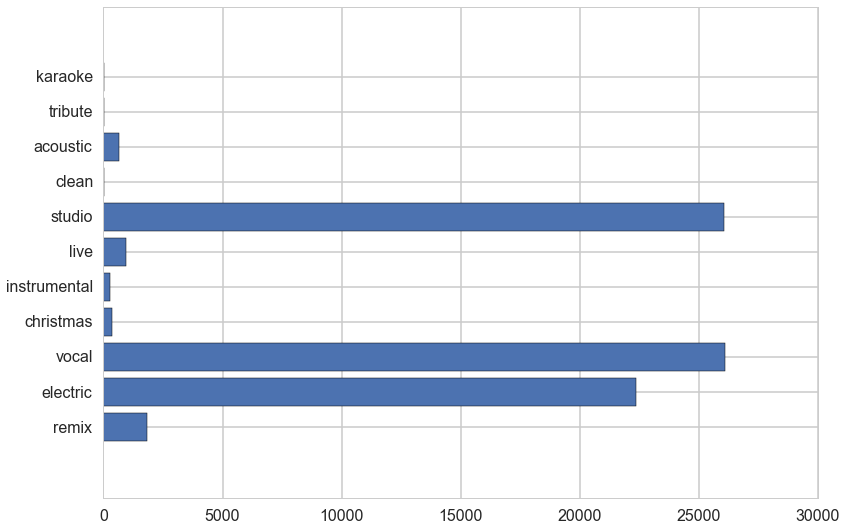

In [170]:
# now that we've got a dictionary, let's plot it!
plt.barh(range(len(songtypedict)), songtypedict.values(), align='center')
plt.yticks(range(len(songtypedict)), songtypedict.keys())

plt.show()


Also of interest to us were the most "popular" artists by their song rankings compared to the ranking provided by Echo Nest. This is of particular significance considering that our training will involve the artist and song ranking that Echo Nest provides. 

We first attempted to assess an artist's popularity by those with the number of songs in the top 1000 ranked first by currency, then by hotness. Currency is a measure of how recently the song trended, and hotness is a measure of the song's performance on social media, reviews, and the like. We then selected the top N and displayed them:

In [ ]:
test = full_df_copy
test = test.sort_values('song_currency', ascending=False)[:1000]
prolific=test.artist_name.value_counts()
prolific[prolific > 15].plot(kind="barh");
#prolific.plot(kind="barh");


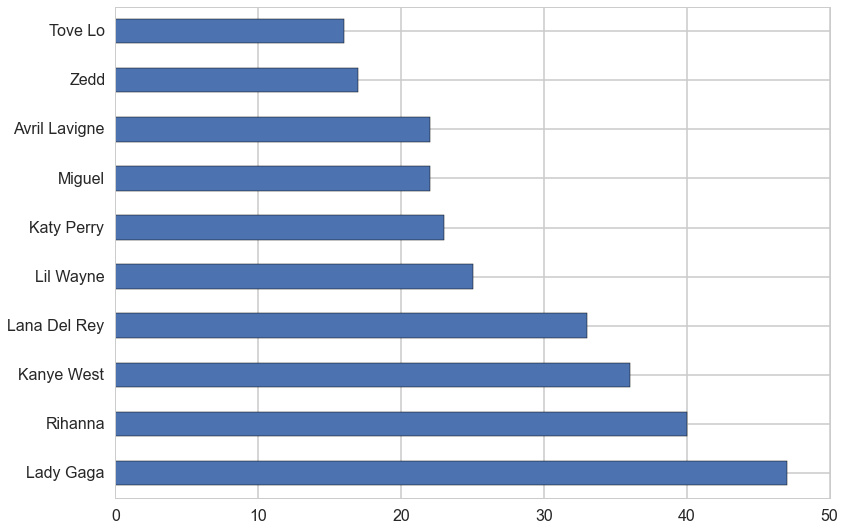

In [131]:
test = test.sort_values('song_hotttnesss', ascending=False)[:1000]
prolific=test.artist_name.value_counts()
prolific[prolific > 15].plot(kind="barh");
#prolific.plot(kind="barh");

Let's compare this with Echo Nest's ranking of artists based on their familiarity, hotness, and discovery metrics (familiarity and hotness are as above, discovery is defined as a metric of how unexpectedly popular an artist is). 

In [132]:
# get just our artist information
artists = test[['artist_discovery_rank','artist_familiarity_rank', 'artist_hotttnesss_rank', 'artist_name']]

# drop duplicates because we have a dataframe full of songs from multiple artists
artists = artists.drop_duplicates()

artists = artists.sort_values('artist_discovery_rank', ascending=False)[:30]
print artists[['artist_discovery_rank', 'artist_name']]

artists = artists.sort_values('artist_familiarity_rank', ascending=False)[:30]
print artists[['artist_familiarity_rank', 'artist_name']]

artists = artists.sort_values('artist_hotttnesss_rank', ascending=False)[:30]
print artists[['artist_hotttnesss_rank', 'artist_name']]

       artist_discovery_rank            artist_name
46488                1214305              Lil Wayne
966                   702686                Nirvana
24085                 679645             Snoop Dogg
15723                 678281              Green Day
39939                 676407                    Nas
4994                  659864              Metallica
3947                  619751  Red Hot Chili Peppers
24146                 602946             Kanye West
27222                 598337                   Kiss
54865                 590954          Stevie Wonder
764                   546383                 Eminem
55730                 521205           Depeche Mode
34574                 512556              Aerosmith
34332                 454334          Guns N' Roses
20341                 453930                 R.E.M.
55581                 435942          Willie Nelson
12143                 413995                  Oasis
28152                 411636           Eric Clapton
31882       

Now let's take a look at our features. Because we'll be using them to predict popularity and rankings, we want to get a better understanding of their distributions. The ones most worthwhile visualizing due to the nature of the features were tempo and duration, referring to the average speed of the song and the time length of the song respectively: 

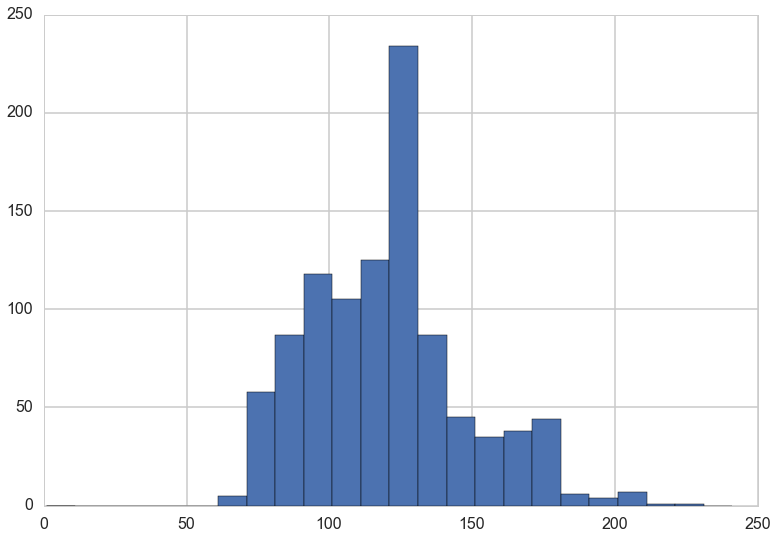

In [133]:
plt.hist(test['tempo'].as_matrix(), bins = np.arange(1,250, 10));

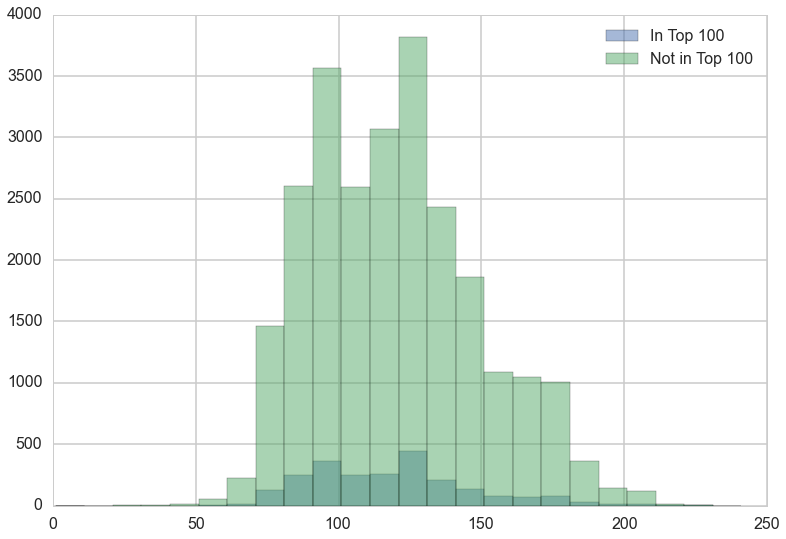

In [134]:
plt.hist(posresponsedf['tempo'].as_matrix(), bins = np.arange(1,250, 10), alpha=0.5, label="In Top 100");
plt.hist(negresponsedf['tempo'].as_matrix(), bins = np.arange(1,250, 10), alpha=0.5, label="Not in Top 100");
plt.legend();

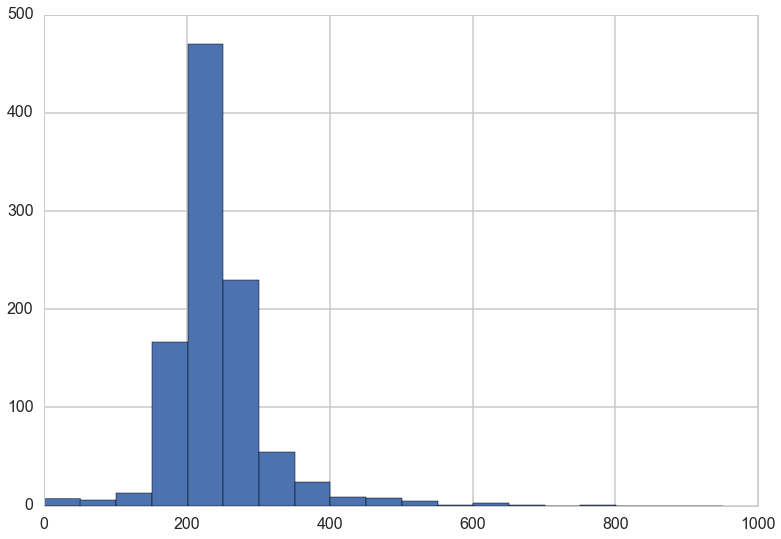

In [135]:
plt.hist(test['duration'].as_matrix(), bins = np.arange(1,1000, 50));

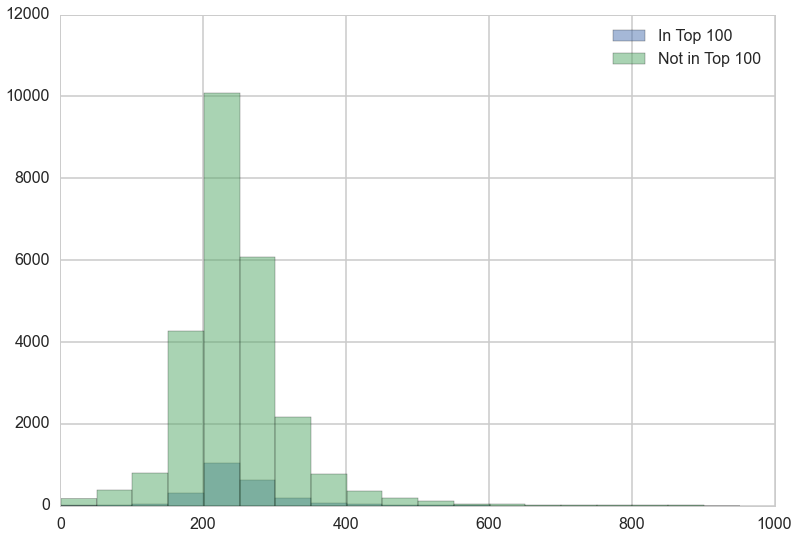

In [136]:
plt.hist(posresponsedf['duration'].as_matrix(), bins = np.arange(1,1000, 50), alpha=0.5, label="In Top 100");
plt.hist(negresponsedf['duration'].as_matrix(), bins = np.arange(1,1000, 50), alpha=0.5, label="Not in Top 100");
plt.xlim(0, 1000)
plt.legend();

But what about the rest of the features? Their distributions might not be relevant or informative because Echo Nest slapped some arbitrary metrics onto them, but we can still see their pairwise correlations: 

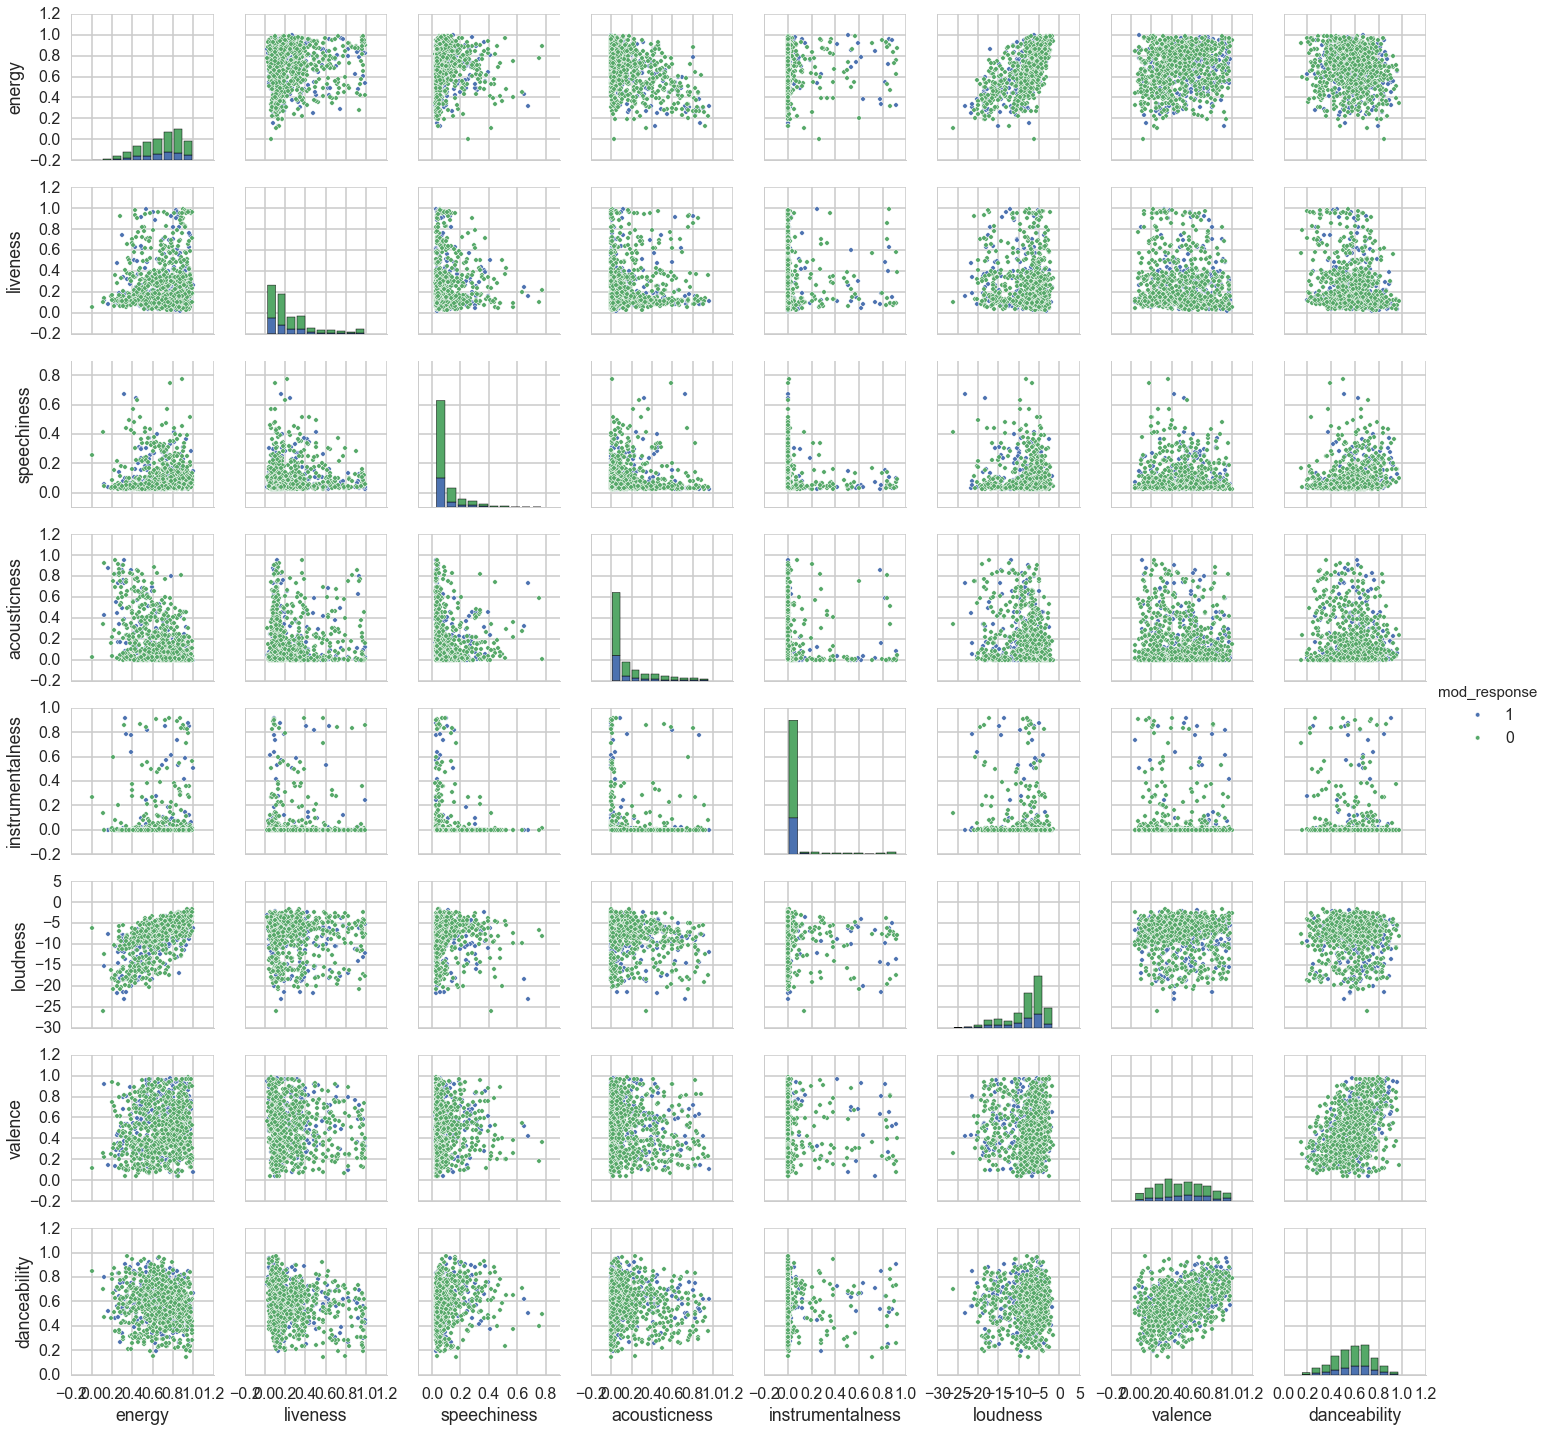

In [137]:
sns.pairplot(test, vars={'acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','valence'}, hue = "mod_response")

This graph shows that our features are not very good for what we are attempting to do. Not only do the green (negative) points outweigh the blue points by a large margin, but we also are unable to see there being significant differences in the predictors for any combination of them.

# Final Analysis

**What did you learn about the data? How did you answer the questions? How can you justify your answers?**

We started by performing a lyric analysis for the lyrics that we could find.

In [ ]:
words, output = gen_database("mxm_dataset_train.txt")
output.update(gen_database("mxm_dataset_test.txt")[1])

# Figure out which songs have lyrics, and read them in
lyrics_songs = []
for a_name,artist in adict.iteritems():
	for s_name,song in artist.songs.iteritems():
		if song.from_database(output):
			lyrics_songs.append(song)

# We no longer need the database
del output

# Get the response variable and the list of IDs
full_response = np.array(fread('full_response.pkl'))
song_ids_list = fread('song_ids_list.pkl')

# Turn this into a dict for indexing
song_ids_dict = {song_ids_list[i]:i for i in xrange(len(song_ids_list))}

# Turn the lyrics into vector format (flatten out the song layer)
lyrics = []
for l in lyrics_songs:
	for i in l.id:
		if i in song_ids_dict:
			lyrics.append([i, full_response[song_ids_dict[i]], l.lyrics])

# Zip into IDs, Y, and X variables
ids, resp, lyrs_raw = zip(*lyrics)

# Flatten this array
lyrs = []
for l in lyrs_raw:
	if l.__class__ == list:
		lyrs.append(l[0])
	else:
		lyrs.append(l)

# Vectorize into a matrix
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer()
v_lyrics = v.fit_transform(lyrs)

# Make sure that we have a training and testing set
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(v_lyrics, resp, test_size=0.33)

# Train + Test on classifier
from sklearn.linear_model import Lasso
clf = Lasso(alpha=0.004)
clf.fit(Xtrain, ytrain)
y_resp = clf.predict(Xtest)

# Turn into vocab so we know the words
vocab = v.vocabulary_
to_word = {}
for i,w in enumerate(words):
	if i in vocab:
		to_word[vocab[i]] = w

# Use the classifier weights
weights = clf.coef_
word_weight = []
for i,w in enumerate(weights):
	word_weight.append((to_word[i], w))

word_weight = sorted(word_weight, key=lambda x: x[1])

# Get back into score form by ID
scores = {}
for i in xrange(len(ids)):
	ly = lyrs[i]
	score = 0
	for k,v in ly.iteritems():
		score += float(v)*weights[vocab[k]]
	scores[ids[i]] = score

# Sanity check to make sure that we have the correct numbers
in_100 = 0
not_in_100 = 0
for i in xrange(len(resp)):
	if resp[i]:
		in_100 += scores[ids[i]]
	else:
		not_in_100 += scores[ids[i]]

print in_100/np.sum(resp)
print not_in_100/(len(resp)-np.sum(resp))

# Output scores
fwrite(scores, "lyric_scores.pkl")

From the analysis that we performed, we were able to see that the lyrics were a better predictor than what we had seen before. There was quite a bit of discriminative power over that of just predicting 0, and we can see that the means of the song distributions are actually pretty far away from each other - from 0.05 to 0.125

In [ ]:
# Create 3x5 grid of graphs
fig, axes = plt.subplots(3, 5, figsize=(30, 30))
for i in range(0,3):
    for j in range(0,5):
        index = (i)*5 + j
        sns.kdeplot(full_df_copy[quantitative_variable_names[index]], color='b', ax=axes[i,j])
            
# Make graphs readable
fig.tight_layout()

In [ ]:
# Log-transform data doesn't seem to help
#log_acousticness = [math.log(list_acousticness + 1) for list_acousticness in acousticness]
#plt.hist(log_acousticness)

In [ ]:
# Separate full_df_copy into positive responses and negative responses
positive_full_df_copy = full_df_copy[response == True]
negative_full_df_copy = full_df_copy[response == False]

# Create 3x5 grid of graphs
fig, axes = plt.subplots(3, 5, figsize=(30, 30))
for i in range(0,3):
    for j in range(0,5):
        # Kernel-density estimate plot positive responses in blue and negative responses in red
        index = (i)*5 + j
        sns.kdeplot(positive_full_df_copy[quantitative_variable_names[index]], color='b', ax=axes[i,j])
        sns.kdeplot(negative_full_df_copy[quantitative_variable_names[index]], color='r', ax=axes[i,j])
            
# Make graphs readable
fig.tight_layout()

We now plot each of the variables to make sure that we are able to figure out if there are large differences in the variables

In [ ]:
# Create 3x5 grid of graphs
fig, axes = plt.subplots(3, 5, figsize=(30, 30))
for i in range(0,3):
    for j in range(0,5):
        # Fitted histogram positive responses in blue and negative responses in red
        index = (i)*5 + j
        positive_full_df_copy[categorical_variable_names[index]].plot(kind='hist', color='b', alpha=.8, ax=axes[i,j], legend=True)
        negative_full_df_copy[categorical_variable_names[index]].plot(kind='hist', color='r', alpha=.5, ax=axes[i,j], legend=True)
            
# Make graphs readable
fig.tight_layout()

In [ ]:
# Split into train and test dataset
from sklearn.cross_validation import train_test_split
#split dataset using the index, as we have x,f, and y that we want to split.
X_train, X_test, y_train, y_test = train_test_split(full_df_copy, response, test_size=0.30)

In [ ]:
# Uneven response variable; more songs not in Billboard Top 100
print len(y_train[y_train == False])
print len(y_train[y_train == True])

In [ ]:
# Use HW 3 code to optimize models
# Import GridSearchCV
from sklearn.grid_search import GridSearchCV
"""
Function
--------
cv_optimize

Inputs
------
clf : an instance of a scikit-learn classifier
parameters: a parameter grid dictionary thats passed to GridSearchCV (see above)
X: a samples-features matrix in the scikit-learn style
y: the response vectors of 1s and 0s (+ives and -ives)
n_folds: the number of cross-validation folds (default 5)
score_func: a score function we might want to pass (default python None)
   
Returns
-------
The best estimator from the GridSearchCV, after the GridSearchCV has been used to
fit the model.
     
Notes
-----
see do_classify and the code below for an example of how this is used
"""
# Define cv_optimized function

def cv_optimize(clf, parameters, X, y, n_folds=5, score_func=None):
    # GridSearchCV
    fitmodel = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    fitmodel.fit(X, y)
    # Return best estimator from grid search
    return fitmodel.best_estimator_

In [ ]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, test_size=0.3, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    X_train, X_test, y_train, y_test = train_test_split(subdf, y, test_size=test_size)
    if parameters:
        clf = cv_optimize(clf, parameters, X_train, y_train, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(X_train, y_train)
    training_accuracy = clf.score(X_train, y_train)
    test_accuracy = clf.score(X_test, y_test)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(y_test, clf.predict(X_test))
    print "########################################################"
    return clf, X_train, y_train, X_test, y_test

Because we don't know which models work best on this data, we generate several models and attempt to see which ones are successful. It will turn out that individually, these are not significantly better than just predicting 0 because of how skewed our dataset is.

In [ ]:
# Try Linear SVC
from sklearn.svm import LinearSVC
clfsvm, X_train_svm, y_train_svm, X_test_svm, y_test_svm = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, full_df_copy_w_response,all_variable_names,'response',True)

In [ ]:
# Try Logistic Regression with Lasso
from sklearn.linear_model import LogisticRegression
# Use do_classify to calculate clflog, Xtrain, ytrain, Xtest, ytest
clflog1, X_train_log1, y_train_log1, X_test_log1, y_test_log1 = do_classify(LogisticRegression(penalty='l1'), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, full_df_copy_w_response,all_variable_names,'response',True)

In [ ]:
# Try Logistic Regression with Ridge
from sklearn.linear_model import LogisticRegression
# Use do_classify to calculate clflog, Xtrain, ytrain, Xtest, ytest
clflog2, X_train_log2, y_train_log2, X_test_log2, y_test_log2 = do_classify(LogisticRegression(penalty='l2'), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, full_df_copy_w_response,all_variable_names,'response',True)

In [ ]:
# Try Decision Trees
from sklearn.ensemble import RandomForestClassifier
# Use do_classify to calculate clflog, Xtrain, ytrain, Xtest, ytest
clfdtree, X_train_dtree, y_train_dtree, X_test_dtree, y_test_dtree = do_classify(RandomForestClassifier(), {"n_estimators": [5, 10, 50]}, full_df_copy_w_response,all_variable_names,'response',True)

In [ ]:
# Function to adjust threshhold proportion binary response data from HW3
def t_repredict(est,t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

In [ ]:
confusion_matrix(y_test,t_repredict(clflog1, 0.05, X_test_log1))

In [ ]:
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

In [ ]:
#notice for the first plot we do not pass an axes object. Subsequent calls to
#make_roc can use the returned axes object ax.
# Plot ROC curves for logistic in blue and SVM in green
with sns.color_palette("bright"):
    ax = make_roc("logistic-with-lasso",clflog1, y_test_log1, X_test_log1, labe=2000, skip=2000)
    ax = make_roc("logistic-with-ridge",clflog2, y_test_log2, X_test_log2, labe=2000, skip=2000)
    ax = make_roc("svm_all-features",clfsvm, y_test_svm, X_test_svm, labe=2000, skip=2000, proba=False)
    ax = make_roc("decision-tree",clfdtree, y_test_dtree, X_test_dtree, labe=2000, skip=2000)

In [ ]:
# Find importance of features based on coefficient weight in classifier
def nonzero_lasso(clf):
    featuremask=(clf.coef_ !=0.0)[0]
    return pd.DataFrame(dict(feature=all_variable_names, coef=clf.coef_[0], abscoef=np.abs(clf.coef_[0])))[featuremask].sort('abscoef', ascending=False)

lasso_importances=nonzero_lasso(clflog1)
lasso_importances.set_index("feature", inplace=True)
lasso_importances.head(10)

In [ ]:
# Find importance of features based on correlation with response
from scipy.stats.stats import pearsonr
correlations=[]
for variable_name in all_variable_names:
    r=pearsonr(X_train[variable_name], y_train)[0]
    correlations.append(dict(feature=variable_name,corr=r, abscorr=np.abs(r)))

bpdf=pd.DataFrame(correlations).sort('abscorr', ascending=False)
bpdf.set_index(['feature'], inplace=True)
bpdf.head(25)

In [ ]:
from sklearn import feature_selection
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

In [ ]:
def pearson_scorer(X,y):
    rs=np.zeros(X.shape[1])
    pvals=np.zeros(X.shape[1])
    i=0
    for v in X.T:
        rs[i], pvals[i]=pearsonr(v, y)
        i=i+1
    return np.abs(rs), pvals    

In [ ]:
selectorlinearsvm = SelectKBest(k=15, score_func=pearson_scorer)
pipelinearsvm = Pipeline([('select', selectorlinearsvm), ('svm', LinearSVC(loss="hinge"))])


In [ ]:
pipelinearsvm, X_train_pipelinearsvm,y_train_pipelinearsvm,X_test_pipelinearsvm,y_test_pipelinearsvm  = do_classify(pipelinearsvm, {"svm__C": [0.00001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, full_df_copy_w_response,all_variable_names,'response',True)

In [ ]:
np.array(lcols)[pipelinearsvm.get_params()['select'].get_support()]

In [ ]:
# Define new do_classify function that balanced dataset
def do_classify_balanced(clf, parameters, indf, featurenames, targetname, target1val, test_size=0.3, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    X_train, X_test, y_train, y_test = train_test_split(subdf, y, test_size=test_size)
    if parameters:
        clf = cv_optimize(clf, parameters, X_train, y_train, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(X_train, y_train)
    training_accuracy = clf.score(X_train, y_train)
    test_accuracy = clf.score(X_test, y_test)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(y_test, clf.predict(X_test))
    print "########################################################"
    return clf, X_train, y_train, X_test, y_test

In [ ]:
# Use do_classify_balanced to train clfsvm_b on balanced set
clfsvm_b, X_train_svm_b, y_train_svm_b, X_test_svm_b, y_test_svm_b = do_classify_balanced(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, full_df_copy_w_response,all_variable_names,'response',True)

In [ ]:
#notice for the first plot we do not pass an axes object. Subsequent calls to
#make_roc can use the returned axes object ax.
# Plot ROC curves for logistic in blue and SVM in green
with sns.color_palette("bright"):
    ax = make_roc("logistic-with-lasso",clflog1, y_test_log1, X_test_log1, labe=200, skip=50)
    ax = make_roc("logistic-with-ridge",clflog2, y_test_log2, X_test_log2, labe=200, skip=50)
    ax = make_roc("svm_all-features",clfsvm, y_test_svm, X_test_svm, labe=200, skip=50, proba=False)
    ax = make_roc("decision-tree",clfdtree, y_test_dtree, X_test_dtree, labe=200, skip=50)
    ax = make_roc("svm_selected-features",pipelinearsvm, y_test_pipelinearsvm, X_test_pipelinearsvm, labe=200, skip=50, proba=False)
    ax = make_roc("svm_balanced",clfsvm_b, y_test_svm_b, X_test_svm_b, labe=200, skip=50, proba=False)

In [ ]:
def do_classify_linear(clf, parameters, indf, featurenames, targetname, test_size=0.3, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=np.array(indf[targetname].tolist())
    X_train, X_test, y_train, y_test = train_test_split(subdf, y, test_size=test_size)
    if parameters:
        clf = cv_optimize(clf, parameters, X_train, y_train, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(X_train, y_train)
    training_accuracy = clf.score(X_train, y_train)
    test_accuracy = clf.score(X_test, y_test)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    return clf, X_train, y_train, X_test, y_test

In [ ]:
from sklearn.linear_model import LinearRegression
clflin_song_rank, X_train_lin_song_rank, y_train_lin_song_rank, X_test_lin_song_rank, y_test_lin_song_rank = do_classify_linear(LinearRegression(), None, full_df_copy_w_response2, all_variable_names_except_song_hotttnesss, 'response')

# Presentation

**Present your final results in a compelling and engaging way using text, visualizations, images, and videos on your project web site.**